<a href="https://colab.research.google.com/github/trszhang/Frog-tail-regeneration/blob/main/_final_project_1_frog_tail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Environment
!pip install -q anndata scanpy numpy pandas scikit-learn matplotlib scipy
!pip install -q "python-igraph>=0.11,<0.12" "leidenalg>=0.10,<0.11"
!pip install -q bbknn harmonypy magic-impute scvi-tools openpyxl

import scanpy as sc
import anndata as ad
import numpy as np, pandas as pd, re
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Paths
from google.colab import drive
drive.mount('/content/drive')
ROOT = Path("/content/drive/MyDrive")
H5AD_FILE = ROOT / "cleaned_processed_frogtail.h5ad"
SUPP_T3_XLSX = ROOT / "Table_S3.xlsx"
OUT_DIR = ROOT / "outputs"; FIG_DIR = OUT_DIR / "figures"
OUT_DIR.mkdir(parents=True, exist_ok=True); FIG_DIR.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = str(FIG_DIR)

# Load data
adata = ad.read_h5ad(H5AD_FILE)
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()
adata.layers["counts"] = adata.X.copy()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 4. Helpers
def base_tag(s):
    return re.sub(r'\.(L|S)$','', str(s).strip(), flags=re.IGNORECASE).upper()

def find_genes(requested, var_names):
    vn = pd.Index(var_names.astype(str))
    wanted = {base_tag(g) for g in requested}
    matches = [g for g in vn if base_tag(g) in wanted]
    return list(dict.fromkeys(matches))  # de-dup, keep order

def show_head(df, n=10, title=None):
    if title:
        print(f"\n=== {title} (top {n}) ===")
    display(df.head(n))

# 5. Subset to Epidermis (according to Figure 1B-like
# Score cells by classic epidermal markers and select top quantile of epidermal cells
epi_markers = find_genes(["tp63","krt5","krt8","krt18"], adata.var_names)
print("Epidermal markers found:", epi_markers)
sc.tl.score_genes(adata, gene_list=epi_markers, score_name="epi_score")

thr = adata.obs["epi_score"].quantile(0.6)
epi = adata[adata.obs["epi_score"] > thr].copy()
print("Epidermis subset:", epi)


Epidermal markers found: ['krt18.L', 'krt8.L', 'krt18.S', 'krt8.S', 'tp63.L', 'tp63.S']
Epidermis subset: AnnData object with n_obs × n_vars = 5280 × 26166
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'epi_score'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'



[Subset: Epidermis]
Epidermal markers found: ['krt18.L', 'krt8.L', 'krt18.S', 'krt8.S', 'tp63.L', 'tp63.S']
Epidermis subset: AnnData object with n_obs × n_vars = 5280 × 26166
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'epi_score'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

[Embedding: PCA→neighbors→UMAP; Clustering: Leiden]


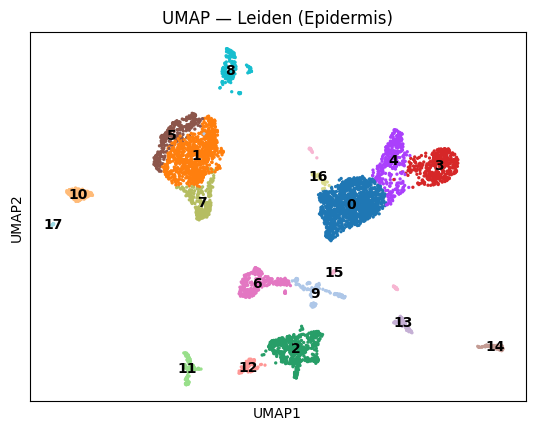

In [ ]:
# 6. Subset to epidermis on .raw/log space
print("\n[Subset: Epidermis]")
epi_markers = find_genes(["tp63","krt5","krt8","krt18"], adata.var_names)
print("Epidermal markers found:", epi_markers)
sc.tl.score_genes(adata, gene_list=epi_markers, score_name="epi_score")
epi = adata[adata.obs["epi_score"] > adata.obs["epi_score"].quantile(0.6)].copy()
print("Epidermis subset:", epi)

# 7. HVGs FOR EMBEDDING ONLY
print("\n[Embedding: PCA→neighbors→UMAP; Clustering: Leiden]")
sc.pp.highly_variable_genes(epi, flavor="seurat_v3", n_top_genes=2000)
epi_hvg = epi[:, epi.var["highly_variable"]].copy()
sc.pp.scale(epi_hvg, max_value=10)
sc.tl.pca(epi_hvg, n_comps=50)
sc.pp.neighbors(epi_hvg, n_neighbors=30, use_rep="X_pca")
sc.tl.umap(epi_hvg, min_dist=0.4, spread=1.0)
sc.tl.leiden(epi_hvg, resolution=0.6, key_added="leiden_epi")

# carry labels back to epi
epi.obs["leiden_epi"] = epi_hvg.obs["leiden_epi"].astype(str)

# Display UMAP with Leiden
sc.pl.umap(
    epi_hvg, color=["leiden_epi"], legend_loc="on data",
    title="UMAP — Leiden (Epidermis)", show=True, save="_epi_leiden.png"
)

In [ ]:
from sklearn.metrics import rand_score
# 8. KMeans & Metrics (ARI, RAND, Silhouette)
print("\n[Clustering metrics: ARI, RAND, Silhouette]")
epi.obs["kmeans_10"] = KMeans(n_clusters=10, random_state=0).fit_predict(epi_hvg.obsm["X_pca"]).astype(str)

labels_leiden = epi.obs["leiden_epi"]
labels_km = epi.obs["kmeans_10"]

ari_lk = adjusted_rand_score(labels_leiden, labels_km)
rand_lk = rand_score(labels_leiden, labels_km)
sil_leiden = silhouette_score(epi_hvg.obsm["X_pca"], labels_leiden)

print(f"Adjusted Rand Index (Leiden vs KMeans):  {ari_lk:.3f}")
print(f"RAND Index (Leiden vs KMeans):           {rand_lk:.3f}")
print(f"Silhouette Score (Leiden clusters):      {sil_leiden:.3f}")



[Clustering metrics: ARI, RAND, Silhouette]
Adjusted Rand Index (Leiden vs KMeans):  0.584
RAND Index (Leiden vs KMeans):           0.867
Silhouette Score (Leiden clusters):      0.295



[ROC scoring & selection]
ROC signature genes found: ['c3.S', 'lef1.L', 'lef1.S', 'msx2.L', 'fgf7.L', 'c3.L', 'fgf7.S', 'msx2.S', 'wnt3a.L', 'wnt3a.S']
ROC cluster: 7
ROC cells: 215
Other cells: 5065


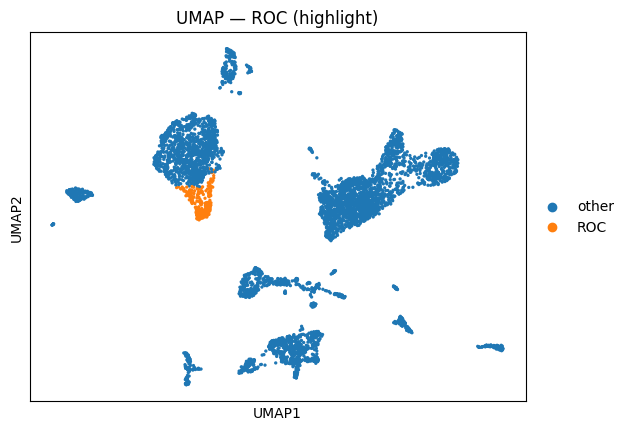

In [ ]:
#9) ROC scoring and cluster selection
print("\n[ROC scoring & selection]")
roc_sig = find_genes(["lef1","fgf7","wnt3a","msx2","c3"], epi.var_names)
print("ROC signature genes found:", roc_sig)
sc.tl.score_genes(epi, gene_list=roc_sig, score_name="roc_score")
roc_cluster = epi.obs.groupby("leiden_epi", observed=True)["roc_score"].mean().idxmax()
epi.obs["isROC"] = (epi.obs["leiden_epi"] == roc_cluster).astype(int)
epi.obs["ROC_state"] = pd.Categorical(
    np.where(epi.obs["isROC"]==1, "ROC", "other"),
    categories=["other","ROC"]
)
print("ROC cluster:", roc_cluster)
print("ROC cells:", int((epi.obs["ROC_state"] == "ROC").sum()))
print("Other cells:", int((epi.obs["ROC_state"] == "other").sum()))

# graph: highlight ROC on UMAP
epi_hvg.obs["ROC_state"] = epi.obs["ROC_state"]
sc.pl.umap(
    epi_hvg, color=["ROC_state"], title="UMAP — ROC (highlight)",
    show=True, save="_epi_ROC_highlight.png"
)


In [ ]:
# 10. Differential Expression on raw with two methods
print("\n[Differential expression: Wilcoxon + Logistic Regression]")
sc.tl.rank_genes_groups(
    epi,
    groupby="ROC_state",
    groups=["ROC"],
    reference="other",
    n_genes=5000,
    method="wilcoxon",
    corr_method="benjamini-hochberg",
    use_raw=True,
    key_added="de_wilcoxon"
)
sc.tl.rank_genes_groups(
    epi,
    groupby="ROC_state",
    groups=["ROC"],
    reference="other",
    n_genes=5000,
    method="logreg",
    max_iter=4000,
    use_raw=True,
    key_added="de_logreg"
)

wdf = sc.get.rank_genes_groups_df(epi, group="ROC", key="de_wilcoxon").rename(columns={"names":"gene"})
ldf = sc.get.rank_genes_groups_df(epi, group="ROC", key="de_logreg").rename(columns={"names":"gene"})
mrk = wdf.merge(ldf, on="gene", how="outer", suffixes=("_wilc","_logreg"))

if "pvals_adj_wilc" in mrk:
    mine = mrk[mrk["pvals_adj_wilc"] < 0.05]["gene"].astype(str).tolist()
else:
    score_cols = [c for c in mrk.columns if "scores_wilc" in c or c.endswith("_wilc") and "scores" in c]
    if score_cols:
        mine = mrk.sort_values(score_cols[0], ascending=False).head(300)["gene"].astype(str).tolist()
    else:
        mine = wdf.sort_values(wdf.filter(like="scores").columns[0], ascending=False).head(300)["gene"].astype(str).tolist()

top_lr = set(mrk.sort_values("scores_logreg", ascending=False).head(300)["gene"].astype(str))
mine_sig = sorted(set(mine) & top_lr) or mine

mine_base = {base_tag(g) for g in mine_sig if isinstance(g, str) and len(g)}
print("Our base genes:", len(mine_base))



[Differential expression: Wilcoxon + Logistic Regression]
Our base genes: 154


Consensus for dotplot: ['Xelaev18000774m.g', 'Xelaev18017960m.g', 'Xelaev18025979m.g', 'Xelaev18026267m.g', 'Xelaev18035740m.g', 'Xelaev18036372m.g', 'Xelaev18038148m.g', 'Xelaev18041485m.g', 'Xelaev18043640m.g', 'Xetrov90029035m.L']


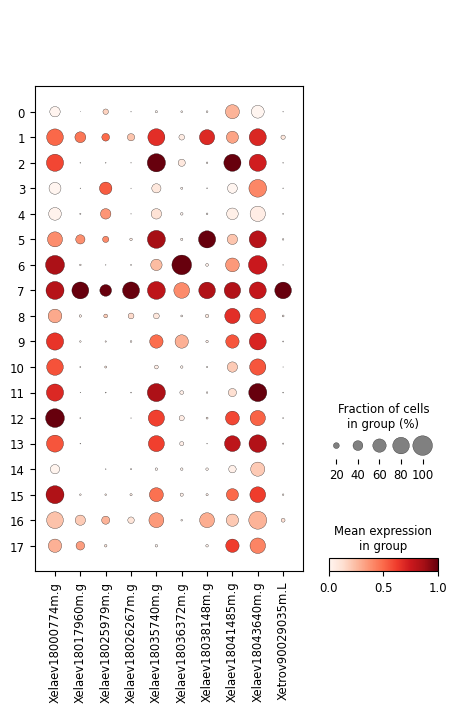

In [ ]:
#11 Figures: dotplot for top consensus genes
# a compact consensus for plotting (top 10)
consensus = (mrk.assign(
    in_w = mrk.filter(like="pvals_adj").min(axis=1) < 0.05 if any(mrk.columns.str.contains("pvals_adj")) else False,
    in_l = mrk.filter(like="scores_logreg").max(axis=1).rank(ascending=False) <= 200
))
try:
    roc_consensus = consensus.query("in_w & in_l")["gene"].head(10).astype(str).tolist()
    if len(roc_consensus) == 0:
        raise ValueError
except Exception:
    roc_consensus = list(pd.Series(list(mine_sig)).dropna().astype(str).unique()[:10])

print("Consensus for dotplot:", roc_consensus)

sc.pl.dotplot(
    epi, var_names=roc_consensus, groupby="leiden_epi",
    standard_scale="var", show=True, save="_epi_ROC_dotplot.png"
)


In [ ]:
# 12. Comparison with Supplementary Table 3
print("\n[Compare to Supplementary Table 3]")
SUPP_T3_XLSX = "/content/drive/MyDrive/TA/supplementary/Table_S3.xlsx"

auth_all = []

sheet_name = "ROC markers"
df = pd.read_excel(SUPP_T3_XLSX, sheet_name=sheet_name, header=None)

gene_pat = re.compile(r"^[A-Za-z][A-Za-z0-9_\-]*((\.L)|(\.S))?$")

for col in df.columns:
    vals = df[col].dropna().astype(str).str.strip()
    if (vals.str.fullmatch(r"\d+")).mean() > 0.3:
        continue

    keep = vals[vals.apply(lambda s: bool(gene_pat.fullmatch(s)))]
    # also allow base names without .L/.S
    keep = pd.concat([keep, vals[vals.str.fullmatch(r"^[A-Za-z][A-Za-z0-9_\-]*$")]])
    keep = keep.drop_duplicates()

    if len(keep) >= 5:
        auth_all.extend(keep.tolist())

auth_base = {base_tag(g) for g in auth_all}
inter_base = sorted(auth_base & mine_base)

print("Author base genes:", len(auth_base))
print("Overlap (base):", len(inter_base))
print("Examples:", inter_base[:20])

# Save comparison
pd.Series(sorted(mine_base)).to_csv(OUT_DIR / "roc_consensus_genes_base.csv", index=False)
pd.Series(sorted(auth_base)).to_csv(OUT_DIR / "supp_table3_genes_base.csv", index=False)
pd.Series(inter_base).to_csv(OUT_DIR / "overlap_genes_base.csv", index=False)



[Compare to Supplementary Table 3]
Author base genes: 45
Overlap (base): 25
Examples: ['CPA6', 'DLX2', 'EGFL6', 'FBN2', 'FGF7', 'FGF9', 'FGFR4', 'FREM2', 'IGFBP2', 'ISM2', 'JAG1', 'KRT', 'LAMB2', 'LEF1', 'LOC100488523', 'LOC100498358', 'LPAR3', 'NID2', 'PLTP', 'RSPO2']


In [ ]:
# 13. Denoising & Integration
print("\n[Denoising: MAGIC & scVI, then Integration: Harmony & BBKNN]")
import magic, scvi, scanpy.external as sce

# MAGIC
mg = magic.MAGIC()
epi_magic = epi.copy()
epi_magic.X = mg.fit_transform(epi_magic.X)
sc.tl.pca(epi_magic, n_comps=50)
sc.pp.neighbors(epi_magic); sc.tl.umap(epi_magic)
sc.tl.leiden(epi_magic, key_added="leiden_magic")
print("ARI MAGIC (Leiden baseline vs MAGIC):",
      adjusted_rand_score(epi.obs["leiden_epi"], epi_magic.obs["leiden_magic"]))

# scVI
scvi.settings.seed = 0
scvi.model.SCVI.setup_anndata(epi, layer="counts")
m = scvi.model.SCVI(epi, n_latent=30)
m.train(max_epochs=200, early_stopping=True)
epi.obsm["X_scvi"] = m.get_latent_representation()
sc.pp.neighbors(epi, use_rep="X_scvi"); sc.tl.umap(epi); sc.tl.leiden(epi, key_added="leiden_scvi")




[Denoising: MAGIC & scVI, then Integration: Harmony & BBKNN]
Calculating MAGIC...
  Running MAGIC on 5280 cells and 26166 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 47.86 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.35 seconds.
    Calculating affinities...
    Calculated affinities in 0.34 seconds.
  Calculated graph and diffusion operator in 48.58 seconds.
  Running MAGIC with `solver='exact'` on 26166-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 61.72 seconds.
Calculated MAGIC in 110.50 seconds.


INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


ARI MAGIC (Leiden baseline vs MAGIC): 0.341390943236752


Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


2025-10-01 21:45:56,738 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-10-01 21:46:03,045 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-10-01 21:46:03,092 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-10-01 21:46:04,989 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-10-01 21:46:06,861 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-10-01 21:46:08,657 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-10-01 21:46:09,905 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-10-01 21:46:13,586 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations



[Save outputs & figures]


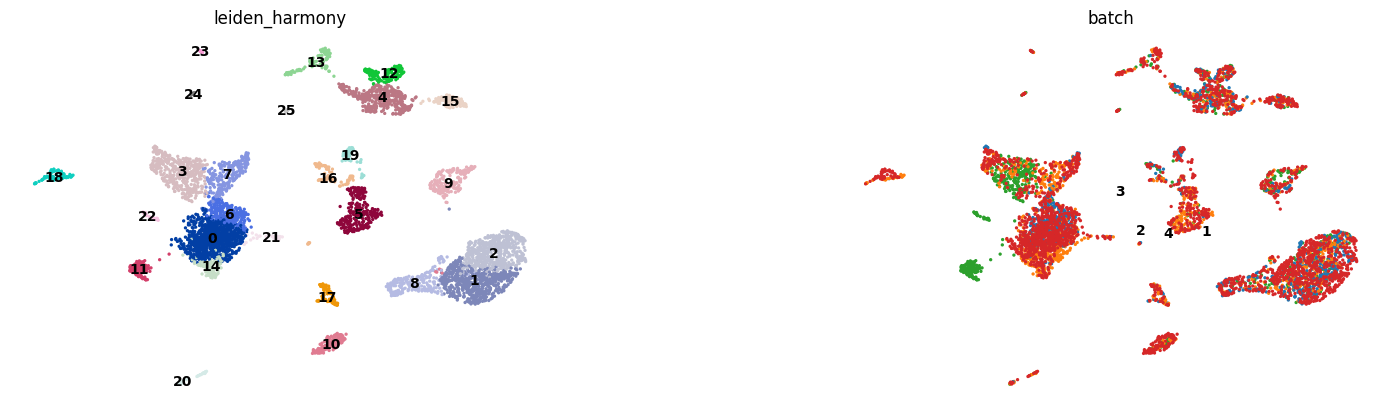

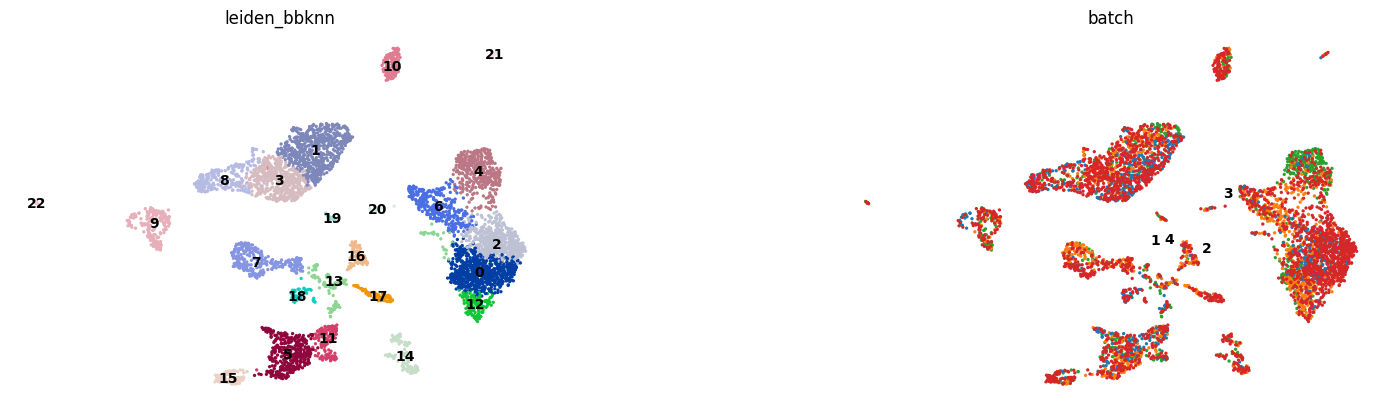

Figures displayed above and also saved to: /content/drive/MyDrive/outputs/figures
Saved outputs to: /content/drive/MyDrive/outputs
Figures saved to: /content/drive/MyDrive/outputs/figures


In [ ]:
# batch: Harmony and  BBKNN
if "batch" not in epi.obs:
    epi.obs["batch"] = "batch0"
epi.obs["batch"] = epi.obs["batch"].astype("category")

if "X_pca" not in epi.obsm:
    sc.pp.scale(epi, max_value=10)
    sc.tl.pca(epi, n_comps=50, svd_solver="arpack")

# Harmony
sce.pp.harmony_integrate(epi, key="batch", basis="X_pca")  # creates .obsm['X_pca_harmony']
sc.pp.neighbors(epi, use_rep="X_pca_harmony")
sc.tl.umap(epi)
sc.tl.leiden(epi, key_added="leiden_harmony")

#BBKNN
epi_bb = epi.copy()
sce.pp.bbknn(epi_bb, batch_key="batch")
sc.tl.umap(epi_bb)
sc.tl.leiden(epi_bb, key_added="leiden_bbknn")
print("\n[Save outputs & figures]")

to_save = pd.DataFrame(index=epi.obs_names)

for col in ["kmeans_10", "ROC_state", "roc_score"]:
    if col in epi.obs:
        to_save[col] = epi.obs[col]

# clustering labels
to_save["leiden_harmony"] = epi.obs["leiden_harmony"]
to_save["leiden_bbknn"] = epi_bb.obs["leiden_bbknn"]

to_save.to_csv(OUT_DIR / "cell_annotations.csv")

# DE tables
wdf.to_csv(OUT_DIR / "DE_wilcoxon_ROC_vs_other.csv", index=False)
ldf.to_csv(OUT_DIR / "DE_logreg_ROC_vs_other.csv", index=False)

#Harmony graph
sc.pl.umap(
    epi,
    color=["leiden_harmony", "batch"],
    wspace=0.4,
    frameon=False,
    legend_loc="on data"
)

# BBKNN graph
sc.pl.umap(
    epi_bb,
    color=["leiden_bbknn", "batch"],
    wspace=0.4,
    frameon=False,
    legend_loc="on data"
)


print("Figures displayed above and also saved to:", FIG_DIR)

print("Saved outputs to:", OUT_DIR)
print("Figures saved to:", FIG_DIR)
